# BERT for Text Classification


#### Task Description：
Fine-tune BERT on the IMDb dataset to determine whether a movie review is positive or negative.

*Example:*  
> Movie Review:  
> Magnificent and unforgettable, stunningly atmospheric, and brilliantly acted by all. I really cannot understand what sort of people are panning this masterpiece and giving the preponderance of votes as 8 (and nine ones!) This, along with Grapes of Wrath, is John Ford's greatest movie. I would say that Long Voyage Home is next in line, though quite a way back. Rating: 10. It deserves a 12.   
>  
> Label: 1  
> (This movie review is positive.) 


#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

## 1. General Preparation

***Please download the pre-trained BERT model into current file.***   
https://drive.google.com/file/d/1kgiwvzfXAzIr_NR2KdY9bSYst69OUFaw/view?usp=sharing

Import some common libraries.

In [1]:
import time
from tqdm import tqdm

Use GPU Facilities.

In [2]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 2. Data Processing

### 2.1 Read data from csv

In [3]:
import pandas as pd

train_data = pd.read_csv("./dataset/text_classification/aclImdb_train.csv", header=0, names=['Text', 'Label'])
test_data = pd.read_csv("./dataset/text_classification/aclImdb_test.csv", header=0, names=['Text', 'Label'])

Let's have a look at the training data.

In [4]:
train_data

,Text,Label
0,"Magnificent and unforgettable, stunningly atmo...",1
1,I got hooked on this as apparently ABC has lic...,1
2,(SPOILERS IN FIRST PARAGRAPH) This movie's ant...,1
3,"Masayuki Suo, who directed this fine film, is ...",1
4,It is a well known fact that when Gene Roddenb...,1
...,...,...
595,Dear me... Peter Sellers was one of the most o...,0
596,It is not often I watch a film that is as drea...,0
597,"Quirky, independent, theatrical, Christian Sla...",0
598,Its plain to see why the makers of Scary Movie...,0


In [5]:
train_data["Label"].value_counts()

1    300
0    300
Name: Label, dtype: int64

In [6]:
# View the first data.
print(u"Text: \n%s\n" % train_data["Text"][0])
print(u"Label: %s" % train_data["Label"][0])

Text: 
Magnificent and unforgettable, stunningly atmospheric, and brilliantly acted by all.<br /><br />I really cannot understand what sort of people are panning this masterpiece and giving the preponderance of votes as 8 (and nine ones!)<br /><br />This, along with Grapes of Wrath, is John Ford's greatest movie. I would say that Long Voyage Home is next in line, though quite a way back.<br /><br />Rating: 10. It deserves a 12.

Label: 1


In [7]:
# Choose how much data to train and test.
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)
train_data["Label"].value_counts()

1    300
0    300
Name: Label, dtype: int64

### 2.2 Tokenization

In [8]:
from tokenization import BertTokenizer

vocab_file = "vocab.txt"
tokenizer = BertTokenizer(do_lower_case=True, model_max_length=512, vocab_file=vocab_file)

# Tokenization
train_encodings = tokenizer(list(train_data["Text"]), padding=True)
test_encodings = tokenizer(list(test_data["Text"]), padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [9]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, list(train_data["Label"]))
test_dataset = IMDbDataset(test_encodings, list(test_data["Label"]))

## 3. Loading the Model and Optimizer 

In [10]:
from bert_model import BertClassification, BertConfig
from torch.optim import AdamW

# Loading the model
configuration = BertConfig()
model = BertClassification(configuration)
model.load_state_dict(torch.load("pretrained_bert.bin")) # load pre-trained model
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

## 4. Training

Prepare some utility functions.

In [11]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [12]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 3

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/3


100%|████████████████████████████████████████████████████| 300/300 [00:59<00:00,  5.08it/s, Loss=0.558, Accuracy=0.670]


Epoch 2/3


100%|████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.68it/s, Loss=0.086, Accuracy=0.872]


Epoch 3/3


100%|████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, Loss=0.068, Accuracy=0.952]


Visualise the training loss and accuracy.

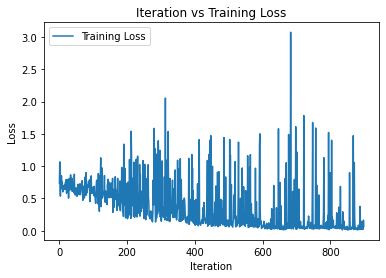

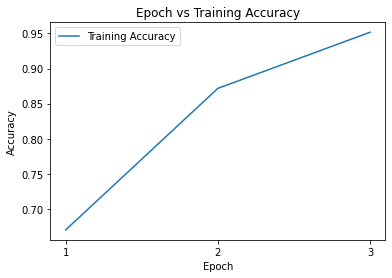

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [14]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|████████████████████████████████████████████████████| 600/600 [00:18<00:00, 31.71it/s, loss=2.868, accuracy=0.832]


The final accuracy on the test dataset: 83.1667%


Check the result.

In [15]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Concat test texts and test records
df = pd.concat([test_data.reset_index(), df_record["Model Prediction"]], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["Label"]!=df["Model Prediction"]]

,index,Text,Label,Model Prediction
1,14,"On monday, earlier this week, sometime in July...",1,0
43,353,The only reason I watched this movie a second ...,0,1
56,434,I enjoyed the beautiful scenery in this movie ...,0,1
59,247,"It occurred to me while watching ""Imaginary He...",1,0
69,147,"Most critics seem to have dismissed this film,...",1,0
...,...,...,...,...
561,52,Bears about as much resemblance to Dean Koontz...,1,0
571,273,This film as it is now is far shorter than it ...,1,0
575,250,Stupidly beautiful. This movie epitomizes the ...,1,0
590,536,The amount of hype and the huge success this f...,0,1


Display the Confusion Matrix of the result.

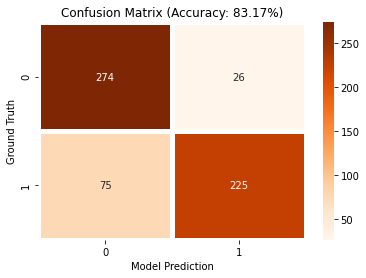

In [16]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

F1-score

In [17]:
precision = crosstab[1][1] / (crosstab[1][1] + crosstab[1][0])
recall = crosstab[1][1] / (crosstab[1][1] + crosstab[0][1])
F1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy: %s%%" % round(accuracy * 100, 2))
print("Precision: %s%%" % round(precision * 100, 2))
print("Recall: %s%%" % round(recall * 100, 2))
print("F1-score: %s%%" % round(F1_score * 100, 2))

Accuracy: 83.17%
Precision: 89.64%
Recall: 75.0%
F1-score: 81.67%


## Manual Test
Now, let's have a manual test on this trained model.
First, you need to input a movie review. Then, our trained model will predict whether this review is positive or negative. In this way, we can check the performance of the model.

To perform a manual test, please run the following code block.

In [18]:
"""
- Manual Test -

Input a movie review. Then, our trained model will predict whether this review is positive or negative.

Example：
Input: "I don't like it, beacuse it is a boring movie. It's kind of waste my time"
Expect: 0 (negative)

"""

manual_test = True
count = 1
print("Let's start our manual test.\n")
time.sleep(0.3)
while(manual_test):
    
    review = input("Please input your test review:\n")

    # Tokenization
    inputs = tokenizer(review, truncation=True, padding=True, return_tensors="pt").to(device)
    
    # Model makes its prediction
    outputs = model(**inputs)
    prediction = predict(outputs)

    # Check the performance
    print("\nThe model thinks this review is %s.\n" % ("negative" if int(prediction)==0 else "positive"))
    
    manual_test = input("Try again? y/n\n")=="y"
    if manual_test:
        count = count + 1
        print("--------------------------------------- %s ---------------------------------------" % count)

Let's start our manual test.

Please input your test review:
I don't like it, beacuse it is a boring movie. It's kind of waste my time

The model thinks this review is negative.

Try again? y/n
y
--------------------------------------- 2 ---------------------------------------
Please input your test review:
I like this movie

The model thinks this review is positive.

Try again? y/n
n
